Previously, we went through the basics in `demo-cf-stacking`; in this demo, we'll focus on experimental methods ... 

### Non-linear latent factor CF 
- Compute user and item embeddings
- Take dot product followed by a non-linear transform

First, let's set up the enviornment and import related libraries ...

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import os, sys

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
# %matplotlib inline

from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

# Progress
from tqdm import tqdm

################################################################
# Configure system environment
# - Please modify input_dir according to your local enviornment
#
################################################################

cur_dir = os.getcwd()
project_dir = 'machine_learning_examples/cf_ensemble'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Adding /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble to sys path ...
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble']


In [2]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)
# import tensorflow_probability as tfp
# tfd = tfp.distributions
from tensorflow import keras

# from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
#################################################################

# Scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#################################################################

# CF-ensemble-specific libraries
import utils_stacking as ustk
import utils_classifier as uclf
import utils_sys as us
import utils_cf as uc 
import scipy.sparse as sparse
from utils_sys import highlight
#################################################################

# Misc
import pprint
import tempfile
from typing import Dict, Text

np.set_printoptions(precision=3, edgeitems=5, suppress=True)

2.8.0


### Generate some data to play with

In [3]:
from sklearn import datasets
from sklearn.datasets import make_classification
from collections import Counter

# get the dataset
def get_dataset(n_samples=5000, noise=True):
    if noise: 
        X,y = make_classification(n_samples=n_samples, n_features=100, n_informative=30, 
                        n_redundant=6, n_repeated=3, n_classes=2, n_clusters_per_class=1,
                            class_sep=2,
                            flip_y=0.2, # <<< 
                            weights=[0.96], random_state=17)
    else: 
        X,y = make_classification(n_samples=n_samples, n_features=100, n_informative=30, 
                            n_redundant=6, n_repeated=3, n_classes=2, n_clusters_per_class=1,
                                class_sep=2, 
                                flip_y=0, weights=[0.96], random_state=17)
    return X, y

X, y =  get_dataset(noise=True)

# Plot data
f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1);
ax1.set_title("With Noise");
plt.show();

uniq_labels = np.unique(y)
n_classes = len(uniq_labels)

# Turn into a binary classification problem 
if n_classes > 2: 
    print('> y before:\n', y)
    y, y_map, le = uclf.to_binary_classification(y, target_class=2)
    print('> y after:\n', y)

print(f'> n_classes: {n_classes}\n{uniq_labels}\n')

counter = Counter(y)
print(f'> counts:\n{counter}\n')

> n_classes: 2
[0 1]

> counts:
Counter({0: 4340, 1: 660})



### Setting up the CF ensemble learner

In [4]:
# Create Base Learners
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators= 200, 
                                                   oob_score = True, 
                                                   class_weight = "balanced", 
                                                   random_state = 20, 
                                                   ccp_alpha = 0.1)), 
                 ('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y))
                                                     , weights = 'distance')),
                #  ('SVC', SVC(kernel = 'linear', probability=True,
                #                    class_weight = 'balanced'
                #                   , break_ties = True)), 

                 ('GNB', GaussianNB()), 
                 ('QDA',  QuadraticDiscriminantAnalysis()), 
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)), 
                 # ('DT', DecisionTreeClassifier(max_depth=5)),
                 # ('GPC', GaussianProcessClassifier(1.0 * RBF(1.0))),
                ]

### Run CF Stacker

In [5]:
from sklearn.metrics import f1_score

n_iter = 1

cf_stackers = []
for i in range(n_iter): 
    # Initialize CF Stacker
    print(f"[info] Instantiate CFStacker #[{i+1}] ...")
    clf = ustk.CFStacker(estimators=base_learners, 
                            final_estimator=LogisticRegression(), 
                            work_dir = input_dir,
                            fold_number = i, # use this to index traing and test data 
                            verbose=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    clf.fit(X_train, y_train)

    X_meta_test = clf.transform(X_test)
    print(f"[info] shape(X_meta_test): {X_meta_test.shape}")

    y_pred = clf.predict(X_test)
    perf_score = f1_score(y_test, y_pred)  # clf.score(X_test, y_test)
    print('[result]', perf_score)

    # Add test label for the convenience of future evaluation after applying a CF ensemble method
    clf.cf_write(dtype='test', y=y_test)

    # keep track of all the stackers (trained on differet parts of the same data as in CV or resampling)
    cf_stackers.append(clf)

[info] Instantiate CFStacker #[1] ...
(BaseCF) base est | name: RF, estimator: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
(BaseCF) base est | name: KNNC, estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')
(BaseCF) base est | name: GNB, estimator: GaussianNB()
(BaseCF) base est | name: QDA, estimator: QuadraticDiscriminantAnalysis()
(BaseCF) base est | name: MLPClassifier, estimator: MLPClassifier(alpha=1, max_iter=1000)
(BaseCF) Base predictors:
[1]  RF: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
[2]  QDA: QuadraticDiscriminantAnalysis()
[3]  MLPClassifier: MLPClassifier(alpha=1, max_iter=1000)
[4]  KNNC: KNeighborsClassifier(n_neighbors=2, weights='distance')
[5]  GNB: GaussianNB()




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[info] Saving X_meta (shape=(3750, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/train-0.npz

[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[info] shape(X_meta_test): (1250, 5)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.6s finished


[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[result] 0.4200913242009133
(cf_write) Adding new attribute y:
[0 1 0 0 0 ... 0 0 0 0 0]
...
(cf_write) Saving X_meta at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz



To speed things up, we can assume that the previous cell was executed at least once so that the necessary level-1 dataset has been generated (probabilty matrix from base classifiers, etc.)

In [6]:
fold_number = 0

# Instantiate a new CFStacker if you do not wish to spend time training base classifiers 
# ... this is ok assuming that pre-trained level-1 datasets are available under ./data
print("[info] Instantiating a new instance of CFStacker bypassing training loop (assuming pre-trained data available) ...")
clf = ustk.CFStacker(estimators=base_learners, 
                    final_estimator=LogisticRegression(), # <<< this is to be changed into a CF ensemble method
                    work_dir = input_dir,
                    fold_number = fold_number, # Use this to index traing and test data 
                    verbose=1)

[info] Instantiating a new instance of CFStacker bypassing training loop (assuming pre-trained data available) ...


In [7]:
# Load pre-trained level-1 data
meta_set = clf.cf_fetch()
X_train, y_train = meta_set['train']['X'], meta_set['train']['y'] 
n_train = X_train.shape[1]
X_test = meta_set['test']['X']
y_test = None
try: 
    y_test = meta_set['test']['y']
except: 
    print("[warning] test label is not available yet. Run the previous code block first.")

# Names of the base classifiers/predictors/estimators
U = meta_set['train']['U']
print(f"[info] list of base classifiers:\n{U}\n")

# Structure the rating/probability matrix
highlight("R: Rataing/probability matrix for the TRAIN set")
R = X_train.T # transpose because we need users by items (or classifiers x data) for CF
n_train = R.shape[1]
L_train = y_train

T = X_test.T
L_test = y_test

# Remember to use "estimated labels" for the test set; not the true label `L_test` that we are trying to predict
p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy='fmax')
lh = uc.estimateLabels(T, p_th=p_threshold) # We cannot use L_test (cheating), but we have to guesstimate
L = np.hstack((L_train, lh)) 
X = np.hstack((R, T))

assert len(U) == X.shape[0]
print(f"> shape(R):{R.shape} || shape(T): {T.shape} => shape(X): {X.shape}")

[info] list of base classifiers:
['RF' 'KNNC' 'GNB' 'QDA' 'MLPClassifier']

R: Rataing/probability matrix for the TRAIN set
(estimateProbThresholds) policy: fmax
> shape(R):(5, 3750) || shape(T): (5, 1250) => shape(X): (5, 5000)


In [8]:
n_factors = 50
alpha = 100.0
beta = 1.0 

# Estimate probability thresholds according to `fmax`
R, T = X[:,:n_train], X[:,n_train:]
L_train = L[:n_train]
# p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy='fmax')

"""
Setting up confidence Matrix.  

Key Parameters 
--------------
X: probabilty/rating matrix, X=[R|T]
L: labels (including the guesstimated labels associated with T)

p_threshold: 
policy_threshold: 'fmax'; this determines how `p_threshold` is estimated

conf_measure: Measure of reliabliity (of probability scores)

alpha: The factor by which confidence scores in C0 is to be scaled 
        in the latent-factor optimization objective
beta: The factor by which TP-specific confidence scores are amplified (
      so that these terms are penalized more severely in the cost function,
      if not approximated well)

"""
########################################################################
CX = uc.evalConfidenceMatrix(X, L=L, U=U, 
                             p_threshold=p_threshold, # not needed if L is given (suggested use: estimate L outside of this call)
                             policy_threshold='fmax',
                             conf_measure='brier', 
                             # alpha=10.0, beta=1.0, # this is now factored into `balance_and_scale`
                             fill=0, is_cascade=True, n_train=n_train, 
                             fold=0, 
                             verbose=0) 
C0, Pc, p_threshold, *CX_res = CX
Cn = uc.mask_neutral_and_negative(C0, Pc, is_unweighted=False, weight_negative=0.0, sparsify=True)
Cn = uc.balance_and_scale(Cn, X=X, L=L, Po=Pc, p_threshold=p_threshold, U=U, 
                    alpha=alpha, 
                        conf_measure='brier', 
                                n_train=n_train, fold=0, verbose=0)
# Cn = uc.shift(Cn, -1.0)
############################################################

(make_cn) Using UNWEIGHTED Cw, non-weighted MF to approximate ratings ...


In [9]:
from numpy import linalg as LA
from scipy.spatial import distance
from sklearn.metrics import f1_score
from analyzer import analyze_matrix_type 
import utils_cf as uc
import cf

fold_number = 0

# Uncomment the following if starting the notebook from here (bypassing training and optimization)
###############################################################################
ret = ustk.get_pretrained_model_with_confidence_matrix(input_dir, 
                                                       base_learners, 
                                                       fold_number, 
                                                       policy_threshold='fmax', 
                                                       conf_measure='brier',
                                                       verbose=1)
X, L, U, p_threshold, n_train = ret['X'], ret['L'], ret['U'], ret['p_threshold'], ret['n_train']
R, T = X[:,:n_train], X[:,n_train:]
Cn, Pc = ret['Cn'], ret['Pc']
###############################################################################
ustk.verify_shape(X, R, T, L, U, p_threshold) # verify the shape of all key quantities

# Load pre-computed latent factors using ALS 
# print(f"[info] Which CFStacker's pre-trained data are we fetching? fold number = {clf.fold_number}") # make sure we get the right meta data

# meta_set = clf.cf_fetch()
# P = meta_set['test']['P']
# Q = meta_set['test']['Q']

# L_test = None
# try: 
#     L_test = meta_set['test']['y'] 
# except: 
#     print("[warning] test label is not available yet. Run the previous code block first.")

def analyze_reconstruction(replace_unreliable_only=False):
    # Re-estimate X (including both R and T)
    Xh = cf.reconstruct(Cn, X, P, Q, 
                    Pc=Pc, 
                    L=L, 
                    # test_labels=np.hstack([L_train, L_test]), # test performance only
                        p_threshold=p_threshold,   
                        policy_opt='rating',  
                        n_train=n_train, # used to split X into (R, T); used only for testing here
                        is_cascade=True,
                            replace_subset=replace_unreliable_only, # set to False to reconstruct the entire matrix X using P and Q
                            name='R+T', index=fold_number)
    
    # [test]
    ####################################
    # 1. Only `Cn` and `Pc` are sparse matrices, all else is dense
    # 2. shape(P): n_users x n_factors
    #    shape(Q): n_items x n_factors 
    #    P Q'    : (n_users, n_factors) x (n_factors, n_items) = (n_users, n_items) = (n_classifiers, sample size)
    # analyze_matrix_type(C=Cn, X=X, P=P, Q=Q, Pc=Pc, L=L)
    assert X.shape == np.dot(P, Q.T).shape
    assert Xh.shape == X.shape
    ####################################

    T = X[:,n_train:]
    Th = Xh[:,n_train:]
    print(f"[info] How different is Th from T? Frobenius norm: {LA.norm(Th-T, ord='fro')}")

    lh0 = uc.estimateLabels(T, L=[], p_th=p_threshold, pos_label=1) # "majority vote given proba thresholds" is the default strategy
    lh = uc.estimateLabels(Th, L=[], p_th=p_threshold, pos_label=1) # Use the re-estimated T to predict labels
    print(f"[info] How different are lh0 and lh? {distance.hamming(lh0, lh)}")

    if L_test is not None: 
        perf_score = f1_score(L_test, lh0)
        print(f'[result] F1 score with the original T: {perf_score}')

        perf_score = f1_score(L_test, lh)  # clf.score(X_test, y_test)
        print(f'[result] F1 score with re-estimated T: {perf_score}')

# analyze_reconstruction(replace_unreliable_only=True)

(estimateProbThresholds) policy: fmax
(make_cn) Using UNWEIGHTED Cw, non-weighted MF to approximate ratings ...


In [10]:
import data_pipeline as dp
df = dp.rating_matrix_to_dataframe(X, shuffle=True)
n_users0, n_items0 = X.shape

# [test]
#########################################
assert df.shape[0] == X.size
# df.astype({'user': 'int32', 'item': 'int64'})
for i, dfi in df.iterrows(): 
    if i > 100: break
    r, c, score = dfi['user'], dfi['item'], dfi['rating']
    assert np.allclose(X[r][c], score)
#########################################

test_size = 0.1
Xc, yc = dp.rating_matrix_to_training_data(X, normalize=False) # NOTE: Don't overwrite X (`Xp` is not the same as the previous `X`, a rating matrix)
X_train, X_val, y_train, y_val = train_test_split(Xc, yc, test_size=test_size, random_state=53)

# train_indices = int((1-test_size) * df.shape[0])
# X_train, X_val, y_train, y_val = (
#     Xp[:train_indices],
#     Xp[train_indices:],
#     yp[:train_indices],
#     yp[train_indices:],
# )

In [11]:
print(f"> shape(X_train): {X_train.shape}, shape(X_val): {X_val.shape}")
assert X.size == X_train.shape[0] + X_val.shape[0]

> shape(X_train): (22500, 2), shape(X_val): (2500, 2)


### Loss function
- Define a confidence-weighted loss fucntion that is also aware of the "color"

In [12]:
# y_pred: f( <x, y> ) # <x, y> denotes the dot product between x and y

def confidence_weighted_loss(y_true, y_pred, weights=None, colors=None): # this has to be used with .add_loss() with greater flexibility
    if weights is None: 
        weights = K.ones_like(y_pred)
    
    if colors is None: 
        # confidence-weighted sum of squares 
        wmse = weights * K.square(y_pred - y_true, axis=-1) # difference between predicted and "true" probability
    else: 
        # condition
        mask_tp = K.equal(colors, 2)
        mask_tn = K.equal(colors, 1)
        mask_fp = K.equal(colors, -2)
        mask_fn = K.equal(colors, -1)

        # if TP, want y_pred >= y_true, i.e. the larger (the closer to 1), the better
        loss_tp = weights * K.square(K.maximum(y_true-y_pred, 0)) # if y_pred > y_true => y_true-y_pred < 0 => no loss, if ow, then the smaller, the higher the penalty (quadratically)
        
        # if TN, want y_pred < y_true, i.e. the smaller (the closer to 0), the better
        loss_tn = weights * K.square(K.maximum(y_pred-y_true, 0)) # if y_true>y_pred => y_pred-y_true < 0 => no loss

        # if FP, y_pred must've been too large, want y_pred smaller 
        loss_fp = loss_tn 
        # loss_fp = weights * K.pow(K.maximum(y_true-y_pred, 0) # may need to be 'a lot' smaller => could penalize error cubically instead

        # if FN, y_pred must've been too small, want y_pred larger
        loss_fn = loss_tp 
        # loss_fn = weights * K.pow(K.maximum(y_pred-y_true, 0), 3) # penalize cubically or any exponent > 2

        wmse = mask_tp * loss_tp + mask_tn * loss_tn + mask_fp * loss_fp + mask_fn * loss_fn
    return wmse

### Create the model

In [13]:
def initialize_base_network(n_factors):
    input = Input(shape=(n_factors, ), name="base_input")
    # x = Flatten(name="flatten_input")(input)
    x = input
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    # K: tensorflow backend
    
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [27]:
n_factors = 50

class CFNet(keras.Model):
    def __init__(self, n_users, n_items, embedding_size, **kwargs):
        super(CFNet, self).__init__(**kwargs)
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_size = embedding_size
        self.user_embedding = Embedding(
            n_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(0.01),
        )
        self.user_bias = Embedding(n_users, 1)

        self.item_embedding = Embedding(
            n_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(0.01),
        )
        self.item_bias = Embedding(n_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])

        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [28]:
n_users = len(np.unique(df['user']))
n_items = len(np.unique(df['item']))
assert n_users == n_users0 == X.shape[0]
assert n_items == n_items0 == X.shape[1]

print(f'[info] shape(X): {X.shape} => n_users={n_users}, n_items={n_items}')
model = CFNet(n_users, n_items, n_factors)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

[info] shape(X): (5, 5000) => n_users=5, n_items=5000


In [29]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/30
352/352 [==============================] - 2s 3ms/step - loss: 1.5090 - val_loss: 1.1623
Epoch 2/30
352/352 [==============================] - 1s 3ms/step - loss: 0.9584 - val_loss: 0.9177
Epoch 3/30
352/352 [==============================] - 1s 3ms/step - loss: 0.7438 - val_loss: 0.6267
Epoch 4/30
352/352 [==============================] - 1s 3ms/step - loss: 0.5736 - val_loss: 0.5512
Epoch 5/30
352/352 [==============================] - 1s 3ms/step - loss: 0.5297 - val_loss: 0.5174
Epoch 6/30
352/352 [==============================] - 1s 3ms/step - loss: 0.5085 - val_loss: 0.5013
Epoch 7/30
352/352 [==============================] - 1s 3ms/step - loss: 0.4938 - val_loss: 0.4887
Epoch 8/30
352/352 [==============================] - 1s 3ms/step - loss: 0.4804 - val_loss: 0.4762
Epoch 9/30
352/352 [==============================] - 1s 3ms/step - loss: 0.4677 - val_loss: 0.4648
Epoch 10/30
352/352 [==============================] - 1s 3ms/step - loss: 0.4576 - val_loss: 0.4579

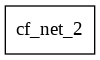

In [31]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='cf-model.png')

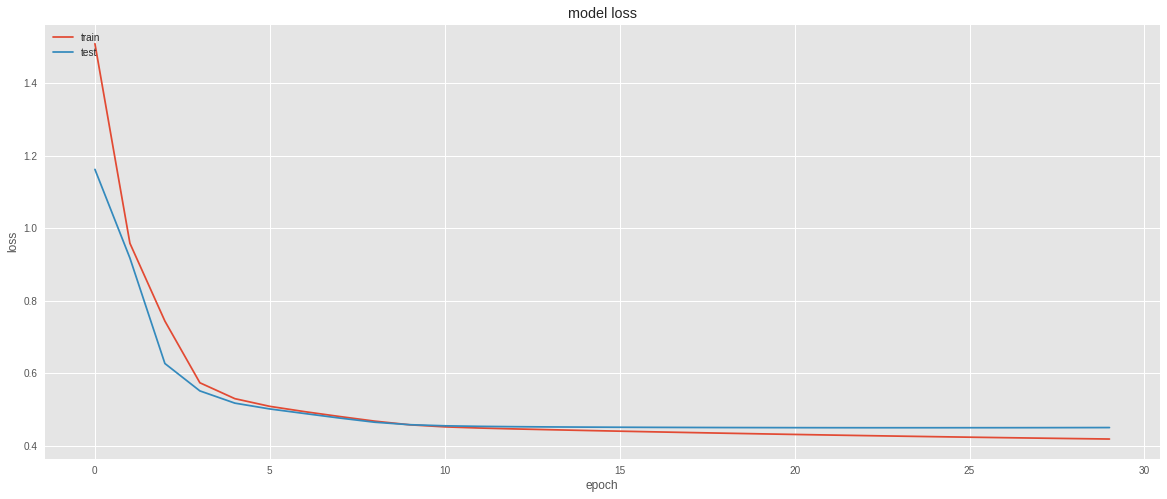

In [30]:
# %matplotlib inline
f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()